# Putting the pieces of kicker data together 
#### Matthew Johnson, August 13, 2018

$KickerPts = 1 *(Made PAT) + 3*(FG_{d\leq 39}) + 4*(FG_{d\in [40,49]}) + 5*(FG_{d\geq 50}) - 1*(Missed FG)$
<br>

- Calculate predictions for data, data + vegas, data + weather, all 3

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.pipeline import Pipeline, make_pipeline
warnings.filterwarnings('ignore')

kickers09to17 = pd.read_csv('kicker_data_09_17.csv')
weather09to13 = pd.read_csv('weather_data09to13.csv') 
vegas09to17 = pd.read_csv('vegas_odds09to17.csv') # Weeks 6-16

dfs = [kickers09to17, weather09to13, vegas09to17]
dfs[1].drop('Unnamed: 0', axis=1, inplace=True)
dfs[2].drop('Unnamed: 0', axis=1, inplace=True)

In [2]:
mergecodes = []
mergecodes2 = []

for df in dfs:
    print (df.shape)
    mergecodes.append(list(df['mergeCode'].unique()))
    mergecodes2.append(list(df['mergeCode2'].unique()))

(2642, 65)
(2058, 16)
(2878, 10)


In [122]:
# deciding whether to merge on mergeCode
A = set(mergecodes[0]) # A - kicker data
B = set(mergecodes[1]) # B - weather
C = set(mergecodes[2]) # C - vegas odds

intersect1 = A.intersection(B)
intersect_all = intersect1.intersection(C)
print('kicker+weather:', len(intersect1))
print('int_all:', len(intersect_all))

kicker+weather: 1270
int_all: 1199


In [123]:
# deciding whether to merge on mergeCode2
A = set(mergecodes2[0]) # A - kicker data
B = set(mergecodes2[1]) # B - weather
C = set(mergecodes2[2]) # C - vegas odds

intersect1 = A.intersection(B)
intersect_all = intersect1.intersection(C)
print('kicker+weather:', len(intersect1))
print('int_all:', len(intersect_all))

kicker+weather: 1330
int_all: 1214


In [5]:
# mergeCode2 it is:
df1 = pd.merge(dfs[0], dfs[1], on='mergeCode2', how='inner')
df2 = pd.merge(df1, dfs[2], on='mergeCode2', how='inner')
print(df2.shape)

(1232, 89)


In [6]:
offenseVariables = ['3rdDown_rate', 'Drive', 'FirstDown','Kicker_Pts',
    'TwoPointConv','Drive_rolling5', 'Kicker_Pts_rolling5', 
    'PointsScored_rolling5', 'Yards.Gained_rolling5', 'FG_range_per_drive', 'RZ_per_drive',
    'punts_per_drive', 'Completion_pct', 'TwoPoint_conv_rate']

defenseVariables = ['DEF_3rdDownSuccess_rolling5', 'DEF_Drive_rolling5', 'DEF_FirstDown_rolling5', 
    'DEF_Kicker_Pts_rolling5',  'DEF_Touchdown_rolling5', 
    'DEF_Yards.Gained_rolling5','DEF_FG_range_per_drive', 'DEF_RZ_per_drive', 'DEF_PointsScored_rolling5',
    'DEF_punts_per_drive', 'DEF_Completion_pct']

generalVariables = ['offenseTeam.1', 'defenseTeam_x', 'Season_x', 'Week_y', 'date_x', 
        'off_score', 'def_score', 'temperature', 'wind_chill', 'humidity', 'wind_mph', 
        'home_team', 'Year', 
        'Relative_Line', 'Total', 'Exp_Pts', 'mergeCode', 'mergeCode2', 'mergeCode_x']

df_off = df2[offenseVariables]
df_def = df2[defenseVariables]
df_gen = df2[generalVariables]

df_gen.columns = ['offenseTeam', 'defenseTeam', 'Season', 'Week', 'date',
       'off_score', 'def_score', 'temperature', 'wind_chill', 'humidity',
       'wind_mph', 'home_team', 'Year', 'Relative_Line', 'Total', 'Exp_Pts', 
       'mergeCode', 'mergeCode2', 'mergeCode_x']

data = pd.concat([df_gen, df_off, df_def], axis=1)
kicker_pts = df2['Kicker_Pts']

In [7]:
# outliers, not currently being used
outliers = data[ (data['Kicker_Pts'] <= 1) | (data['Kicker_Pts'] >= 25)]
outliers.shape
#data_drop_outliers = data[ (data['Kicker_Pts'] >= 1) | (data['Kicker_Pts'] <= 25)]

(65, 44)

**We remove the 'off_score' and 'def_score' due to those being unknown quantities pre game, leaving these in would cause data leakage.**

In [8]:
data2 = data.drop(['off_score', 'def_score'], axis=1)
data2['Season'] = data2['Season'].astype('category')
data2['Week'] = data2['Week'].astype('category')
data2['Year'] = data2['Year'].astype('category')

num_data = data2.select_dtypes(include=['int64', 'float64'])

**Visualizing Kicker_Pts distribution:**

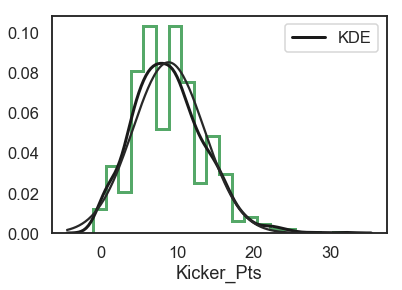

In [115]:
from scipy.stats import norm

sns.distplot(kicker_pts, bins=20, fit=norm,
            kde_kws={"color": "k", "lw": 3, "label": "KDE"},
            hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "g"});

### Correlations:

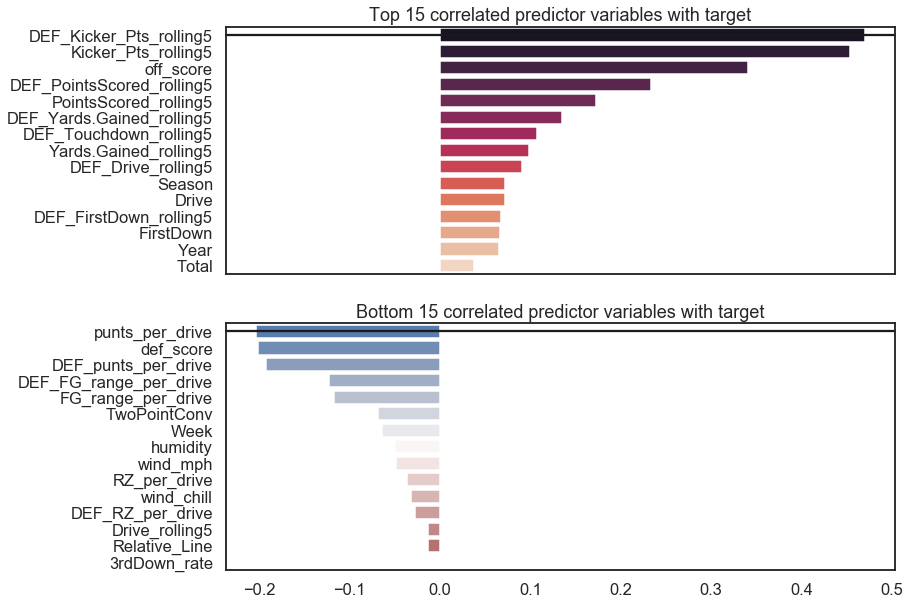

In [119]:
sns.set(style="white", context="talk")

corr = data.corr()['Kicker_Pts'].sort_values(ascending=False)

corr_rank_high = corr_rank[1:16]
corr_rank_low = corr_rank[-18:-3].sort_values(ascending=True)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.barplot(y=corr_rank_high.index, x=corr_rank_high.values, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_title('Top 15 correlated predictor variables with target')

sns.barplot(y=corr_rank_low.index, x=corr_rank_low.values, palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_title('Bottom 15 correlated predictor variables with target');

It seems as the defensive quantities are slightly more correlated in a few aspects including their last 5 game mean of allowed Kicker Pts (DEF_Kicker_Pts_rolling5) vs the kicker's team's last 5 game mean of Kicker Pts scored(Kicker_Pts_rolling5) and Points Allowed (DEF_PointsScored_rolling5) vs Points Scored (PointsScored_rolling5) moving averages.<br>
On the other end of the spectrum, the more a team punts in relation to the number of drives (punts_per_drive) the worse the performance of the kicker. 

### Modelling

In [12]:
from sklearn.linear_model import ElasticNet, Lasso, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [17]:
rolling_kpts = num_data['Kicker_Pts_rolling5'].copy()
rolling_kpts.columns = ['Kicker_Pts_rolling5b']
def_rolling_kpts = num_data['DEF_Kicker_Pts_rolling5'].copy()
def_rolling_kpts.columns = ['DEF_Kicker_Pts_rolling5b']

In [20]:
from scipy.stats import norm, skew

all_data = num_data.drop(['Kicker_Pts', 'Relative_Line', 'TwoPoint_conv_rate'], axis=1)

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()


Skew in numerical features: 



,Skew
TwoPointConv,5.544
3rdDown_rate,4.762
DEF_3rdDownSuccess_rolling5,3.305
wind_mph,1.306
DEF_FirstDown_rolling5,0.344


In [21]:
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
#skewed_features = skewed_features.drop(['Relative_Line', 'TwoPoint_conv_rate'])
print("There are {} skewed numerical features to Box Cox transform".format(len(skewed_features)))

lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data = pd.concat([all_data, num_data['Relative_Line']], axis=1)

There are 29 skewed numerical features to Box Cox transform


In [22]:
all_data['3rdDown_rate'].fillna(all_data['3rdDown_rate'].mean(), inplace=True)
all_data['wind_chill'].fillna(all_data['temperature'], inplace=True)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = pd.concat([all_data, rolling_kpts, num_data['Relative_Line']], axis=1)
y = kicker_pts

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 2018)
rf2.fit(Xtrain, ytrain);

In [28]:
predictions2 = rf2.predict(Xtest)
errors = abs(predictions2 - ytest)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 3.02


In [256]:
predictions2 = rf2.predict(Xtest)
errors = abs(predictions2 - ytest)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 2.84


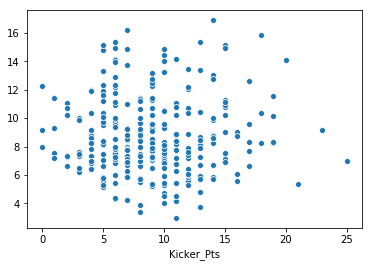

In [257]:
sns.scatterplot(x=ytest, y=predictions);

In [60]:
rf_df = pd.DataFrame({'feature': pd.Series(X.columns),'importance': rf2.feature_importances_})
rf_df.sort_values(by='importance', ascending=False)[0:10]

,feature,importance
21,DEF_Kicker_Pts_rolling5,0.150
11,Kicker_Pts_rolling5,0.114
29,Kicker_Pts_rolling5,0.099
8,FirstDown,0.041
23,DEF_Yards.Gained_rolling5,0.039
16,punts_per_drive,0.038
13,Yards.Gained_rolling5,0.037
25,DEF_RZ_per_drive,0.033
12,PointsScored_rolling5,0.032
0,temperature,0.032


In [42]:
pred_df = pd.DataFrame({'Actual': ytest, 'Pred': predictions2, 'Rolling':Xtest['Kicker_Pts_rolling5'].iloc[:,1]})

pred_df['residual'] = abs(pred_df['Actual'] - pred_df['Pred'])
pred_df['roll_res'] = abs(pred_df['Actual'] - pred_df['Rolling'])


In [44]:
pred_df.describe()

,Actual,Pred,Rolling,residual,roll_res
count,308.000,308.000,308.000,308.000,308.000
mean,8.828,8.945,8.750,3.025,3.422
std,4.787,2.697,2.131,2.469,2.657
min,0.000,3.540,3.000,0.025,0.000
25%,5.000,6.837,7.000,1.003,1.000
50%,8.000,8.747,9.000,2.502,3.000
75%,12.000,10.750,10.000,4.354,5.000
max,28.000,15.183,15.000,15.441,18.000


In [161]:
pred_df = pd.DataFrame({'Actual': ytest, 'Pred': predictions})

In [166]:
pred_df['residual'] = abs(pred_df['Actual'] - pred_df['Pred'])

good_guess = pred_df[ pred_df['residual'] <= 2.0 ]
good_guess.sort_values(by='residual').head()

,Actual,Pred,residual
498,8,7.975,0.025
869,7,6.965,0.035
278,9,9.048,0.048
233,9,9.088,0.088
1224,8,7.896,0.104


In [168]:
poor_guess = pred_df[ pred_df['residual'] >= 7.0 ]
poor_guess.sort_values(by='residual', ascending=False).head()

,Actual,Pred,residual
596,23,10.702,12.298
984,18,7.133,10.867
719,18,7.186,10.814
539,18,7.853,10.147
1076,22,13.300,8.700


In [169]:
pred_df.describe()

,Actual,Pred,residual
count,308.000,308.000,308.000
mean,8.919,8.693,2.985
std,4.474,2.662,2.246
min,-1.000,2.970,0.025
25%,6.000,6.952,1.158
50%,9.000,8.165,2.600
75%,12.000,10.236,4.296
max,23.000,16.889,12.298


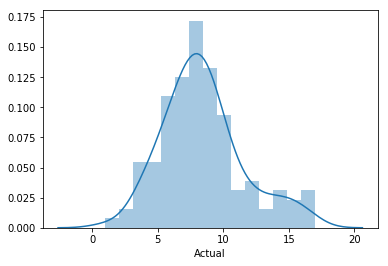

In [176]:
sns.distplot(good_guess['Actual'], bins=15)

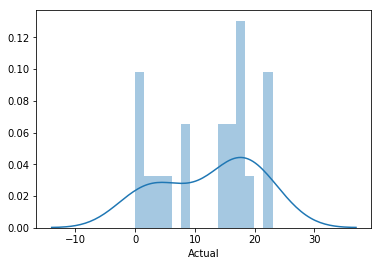

In [175]:
sns.distplot(poor_guess['Actual'], bins=15)

In [65]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.1000, gamma=0.000, 
                             learning_rate=0.05, max_depth=1, 
                             min_child_weight=20.000, n_estimators=3338,
                             reg_alpha=10.000, reg_lambda=0,
                             subsample=1.000, silent=1,
                             random_state =2018, nthread = -1)

In [79]:
X = pd.concat([all_data, num_data['Relative_Line']], axis=1)
y = kicker_pts

In [80]:
model_xgb.fit(X, y)

scores_xgb = cross_val_score(model_xgb, X, y, cv=10)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

Accuracy: 0.2851 (+/- 0.1233)


In [88]:
X2 = pd.concat([X,y], axis=1)
#X2 = X2[['Kicker_Pts_rolling5', 'Kicker_Pts']]
X2['dev_from_mean'] = X2['Kicker_Pts_rolling5']-X2['Kicker_Pts']
X2['abs'] = abs(X2['dev_from_mean'])

In [124]:
X2.corr()['dev_from_mean'].sort_values(ascending=False)[0:10]

dev_from_mean            1.000
DEF_punts_per_drive      0.192
punts_per_drive          0.178
DEF_FG_range_per_drive   0.122
FG_range_per_drive       0.104
wind_chill               0.061
humidity                 0.061
TwoPointConv             0.060
wind_mph                 0.045
RZ_per_drive             0.032
Name: dev_from_mean, dtype: float64

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [130]:
rfr=RandomForestRegressor(random_state=2018)

param_grid = { 
    'n_estimators': [1000, 2000, 3000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
}

In [131]:
CV_rfc = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5)
CV_rfc.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=2018, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1000, 2000, 3000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [132]:
rfr_pred = CV_rfc.predict(Xtest)

In [133]:
abs(ytest-rfr_pred).mean()

3.0385208846589027